In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00


# Classificador de cores de cartas do Magic the Gathering


#### aluno: RAFAEL MAGNO FREITAS NUNES




## 1. Introdução

Este projeto aplica técnicas de Processamento de Linguagem Natural (PLN) para classificar cartas do jogo Magic: The Gathering com base em suas cores (Branco, Azul, Preto, Vermelho e Verde), a partir do texto presente nas próprias cartas. A abordagem é fundamentada no uso de modelos Transformer, especialmente o BERT pré-treinado em português, que passa por uma adaptação ao domínio (Domain-Adaptive Pretraining) e posterior especialização supervisionada (fine-tuning) para a tarefa de classificação.

Magic: The Gathering é um jogo com cartas que contêm descrições textuais complexas, escritas em linguagem natural. Cada cor representa um estilo distinto de jogo e se reflete no vocabulário e na estrutura do texto das cartas. Isso torna a classificação por cor uma tarefa adequada para PLN, pois há relação semântica consistente entre o conteúdo textual e a cor associada à carta.


ddfce87c-52d8-564e-bd78-457669f09e2e_3a0df424-19d8-4009-83b6-9b99dca2b351.jxl

## 2. Coleta e Processamento de Dados

### coleta

A base de dados utilizada foi construída a partir de requisições de uma API do Magic: The Gathering. Foram coletadas até 300 páginas de dados, contendo informações sobre as cartas, filtrando apenas aquelas que:

- Possuem uma única cor (para classificação monocromática);

- Contêm descrições em português (campos text, flavor e name);

- Incluem as informações necessárias para análise textual.

As informações relevantes foram salvas em um arquivo .csv para uso posterior.

In [3]:
import requests
import csv

API_URL = "https://api.magicthegathering.io/v1/cards"
OUTPUT_FILE = "mtg_cards_ptbr.csv"
PAGE_SIZE = 100  # máximo permitido


In [4]:
def extract_valid_card_data(card, multilabel: bool = False):
    colors = card.get("colors", [])

    # Multilabel: aceita listas com pelo menos 1 cor
    # TODO (s4lo): implement multilabel classification if time allow
    if multilabel:
        if not isinstance(colors, list) or len(colors) == 0:
            return None
    else:
        if not isinstance(colors, list) or len(colors) != 1:
            return None

    foreign_names = card.get("foreignNames", [])
    for entry in foreign_names:
        if entry.get("language") == "Portuguese (Brazil)":
            required_fields = ["language", "text", "flavor", "name"]
            if all(entry.get(k) and str(entry[k]).strip() for k in required_fields):
                return {
                    "colors": ','.join(colors),
                    "language": entry["language"],
                    "type": entry["type"],
                    "text": entry["text"],
                    "flavor": entry["flavor"],
                    "title": entry["name"]
                }
    return None

def collect_cards(max_pages=None):
    collected_data = []
    page = 1
    while True:
        if max_pages is not None and page > max_pages:
            print("page limit.")
            break
        response = requests.get(API_URL, params={"page": page, "pageSize": PAGE_SIZE})
        if response.status_code != 200:
            print(f"error page {page}: {response.status_code}")
            break
        cards = response.json().get("cards", [])
        if not cards:
            break  # fim dos dados
        for card in cards:
            data = extract_valid_card_data(card)
            if data:
                collected_data.append(data)
        print(f"{page},", end="")
        page += 1
    return collected_data


def save_to_csv(data, filename):
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["colors", "language", "type", "text", "flavor", "title"])
        writer.writeheader()
        writer.writerows(data)



In [5]:
print("Iniciando coleta de dados da API MTG...")
cards_data = collect_cards(max_pages=300)
print(f"Total de cartas válidas coletadas: {len(cards_data)}")
save_to_csv(cards_data, OUTPUT_FILE)
print(f"Dados salvos em: {OUTPUT_FILE}")


Iniciando coleta de dados da API MTG...
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,

In [6]:

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.graph_objects as go
import re

df = pd.read_csv(OUTPUT_FILE) # main
df

,colors,language,type,text,flavor,title
0,W,Portuguese (Brazil),Criatura — Humano Clérigo,Iniciativa (Esta criatura causa dano de combat...,"""A vontade de todos pelas minhas mãos realizada.""",Eleito da Ancestral
1,W,Portuguese (Brazil),Criatura — Anjo,Voar (Esta criatura só pode ser bloqueada por ...,Cada lágrima derramada é uma gota de imortalid...,Anjo de Misericórdia
2,W,Portuguese (Brazil),Feitiço,A criatura alvo recebe +3/+3 e ganha a habilid...,Somente o guerreiro que for capaz de admitir s...,Bênção Angelical
3,W,Portuguese (Brazil),Encantamento,Toda vez que uma criatura entra em jogo sob se...,A harmonia do glorioso é um lamento para o per...,Coro Angelical
4,W,Portuguese (Brazil),Criatura — Barreira,"Defensor, voar (Esta criatura não pode atacar,...","""A Ancestral nos protege de maneiras que nos é...",Barreira Angelical
...,...,...,...,...,...,...
4609,G,Portuguese (Brazil),Encantamento,Criaturas sem habilidades recebem +2/+2.,Alguns magos abandonam seus pergaminhos e bibl...,Petróglifos de Muraganda
4610,G,Portuguese (Brazil),Feitiço,Revele qualquer número de cards em sua mão. Vo...,"""A Rainha Cogumelo entre seus esporos deixa-se...",Banquete Fosforescente
4611,G,Portuguese (Brazil),Criatura — Trasgo,Mágicas que têm como alvo Trasgo Jogapraga cus...,"""Seus grandes olhos brilhantes podem parecer c...",Trasgo Jogapraga
4612,G,Portuguese (Brazil),Criatura — Arqueiro Elfo,Alcance (Esta criatura pode bloquear criaturas...,Suas flechas são envenenadas com olhos de basi...,Arqueiro de Espinoflora


###  Limpeza e Preparação dos Dados

Foi criado um pipeline de limpeza textual com as seguintes etapas:

- Remoção de quebras de linha e espaços excessivos;


- Normalização do texto, com concatenação dos campos de título, texto e flavor.

Durante o processo de limpeza textual, foi realizada a substituição dos símbolos de mana {W}, {U}, {B}, {R}, {G} por um marcador genérico {M}. Esta escolha foi feita pois manter os símbolos de mana específicos poderia facilitar que o modelo inferisse a cor da carta com base nesses símbolos presentes no texto — o que levaria a um aprendizado superficial, baseado em pistas explícitas, e não em padrões linguísticos mais gerais. Substituí-los por um marcador único força o modelo a depender da estrutura do texto e não de tokens diretamente correlacionados ao rótulo.

O texto resultante foi armazenado na nova coluna raw_text, usada como entrada textual para os modelos.

In [7]:
import re
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Funções de limpeza
def remove_excessive_whitespace(text: str) -> str:
    return re.sub(r"\s+", " ", text).strip()

def remove_break_lines(text: str) -> str:
    return re.sub(r"\n", " ", text).strip()

def remove_whitespace_before_punctuation(text: str) -> str:
    return re.sub(r"\s+([.,!?:])", r"\1", text).strip()

def replace_mana_symbols(text: str) -> str:
    return re.sub(r"\{[WUBRG]\}", "{M}", text)

def full_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = remove_break_lines(text)
    text = remove_excessive_whitespace(text)
    text = remove_whitespace_before_punctuation(text)
    text = replace_mana_symbols(text)
    return text

# Pipeline com função de limpeza completa
text_cleaning_pipeline = Pipeline(
    steps=[
        ("clean_text", FunctionTransformer(full_clean, validate=False))
    ]
)

# Criar nova coluna 'raw_text' com o texto limpo concatenado
df["raw_text"] = (
    df["title"].apply(text_cleaning_pipeline.transform) + " - " +
    df["text"].apply(text_cleaning_pipeline.transform) + " " +
    df["flavor"].apply(text_cleaning_pipeline.transform)
).str.strip()

df["raw_text"]

,raw_text
0,Eleito da Ancestral - Iniciativa (Esta criatur...
1,Anjo de Misericórdia - Voar (Esta criatura só ...
2,Bênção Angelical - A criatura alvo recebe +3/+...
3,Coro Angelical - Toda vez que uma criatura ent...
4,"Barreira Angelical - Defensor, voar (Esta cria..."
...,...
4609,Petróglifos de Muraganda - Criaturas sem habil...
4610,Banquete Fosforescente - Revele qualquer númer...
4611,Trasgo Jogapraga - Mágicas que têm como alvo T...
4612,Arqueiro de Espinoflora - Alcance (Esta criatu...


### Análise Exploratória

Antes do treinamento do modelo, foi realizada uma análise exploratória dos dados:

- Distribuição do número de palavras por texto;

- Frequência das palavras mais comuns;

- Distribuição das combinações de cores.

Essas análises permitiram entender melhor a natureza do corpus textual e a complexidade da tarefa de classificação.

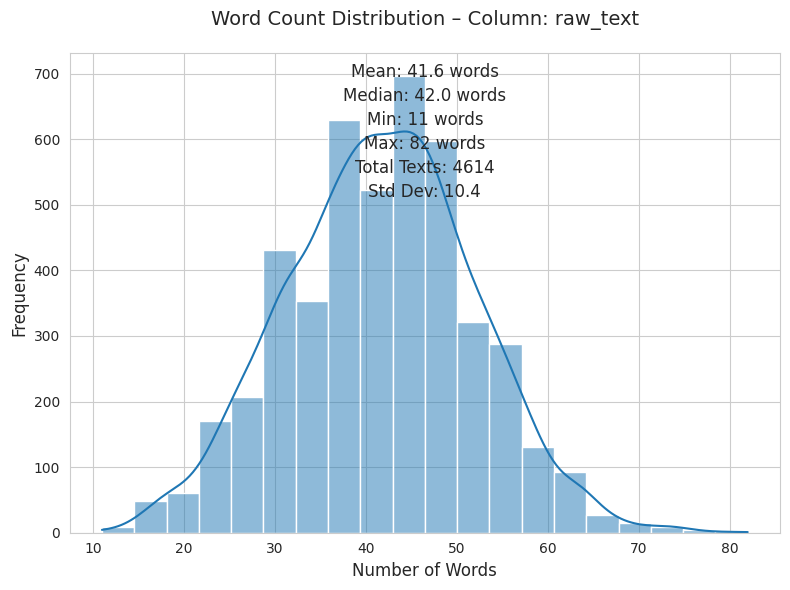

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_word_count_distribution(df, column: str, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Compute word counts
    word_counts = df[column].astype(str).str.split().apply(len)
    stats = word_counts.describe()

    # Plot histogram with density line
    sns.histplot(word_counts, bins=20, kde=True)
    plt.title(f"Word Count Distribution – Column: {column}", fontsize=14, pad=20)
    plt.xlabel("Number of Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    # Overlay statistical summaries
    plt.text(0.5, 0.95, f"Mean: {stats['mean']:.1f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.9, f"Median: {stats['50%']:.1f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.85, f"Min: {stats['min']:.0f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.8, f"Max: {stats['max']:.0f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.75, f"Total Texts: {stats['count']:.0f}",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.7, f"Std Dev: {stats['std']:.1f}",
             transform=plt.gca().transAxes, ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


plot_word_count_distribution(df, column="raw_text")



In [9]:
from collections import Counter
import plotly.graph_objects as go

def plot_histogram_word(df, column: str, n_most_common=30, suffix=""):
    # Flatten all words in the column into a list
    words = [
        word
        for text in df[column].dropna().astype(str)
        for word in text.split()
    ]

    total_words = len(words)
    unique_tokens = len(set(words))
    word_counts = Counter(words)
    top_words = dict(word_counts.most_common(n_most_common))

    # Plotting
    fig = go.Figure([
        go.Bar(
            x=list(top_words.keys()),
            y=list(top_words.values()),
            text=list(top_words.values()),
            textposition="auto",
        )
    ])

    fig.update_layout(
        title_text=(
            f"Top {n_most_common} Most Frequent Words {suffix}<br>"
            f"Total Words: {total_words} • Unique Tokens: {unique_tokens}"
        ),
        title_x=0.5,
        xaxis_title="Words",
        yaxis_title="Frequency",
        xaxis_tickangle=-45,
    )

    fig.show()
plot_histogram_word(df, column="raw_text", n_most_common=40, suffix="(with stopwords)")


Unique colors combinations:
['W' 'U' 'B' 'R' 'G']


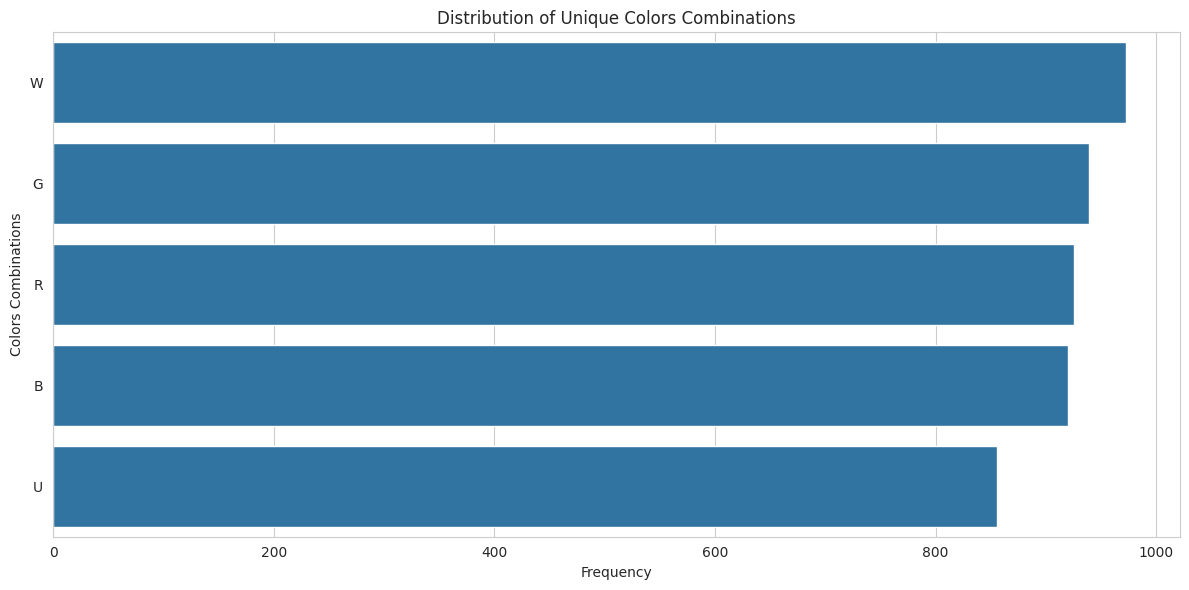

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colors_combinations_distribution(df, target_column):
    # Convert arrays to sorted strings for consistent representation
    combinations_str = df[target_column].apply(lambda x: ", ".join(sorted(x)) if isinstance(x, (list, tuple)) else str(x))

    unique_combinations = combinations_str.unique()
    print(f"Unique {target_column} combinations:")
    print(unique_combinations)

    plt.figure(figsize=(12, 6))
    sns.countplot(y=combinations_str, order=combinations_str.value_counts().index)
    plt.title(f"Distribution of Unique {target_column.capitalize()} Combinations")
    plt.xlabel("Frequency")
    plt.ylabel(f"{target_column.capitalize()} Combinations")
    plt.tight_layout()
    plt.show()

plot_colors_combinations_distribution(df, "colors")



In [11]:
df.to_csv('dataset.csv', index=False)
df[['colors','raw_text']]

,colors,raw_text
0,W,Eleito da Ancestral - Iniciativa (Esta criatur...
1,W,Anjo de Misericórdia - Voar (Esta criatura só ...
2,W,Bênção Angelical - A criatura alvo recebe +3/+...
3,W,Coro Angelical - Toda vez que uma criatura ent...
4,W,"Barreira Angelical - Defensor, voar (Esta cria..."
...,...,...
4609,G,Petróglifos de Muraganda - Criaturas sem habil...
4610,G,Banquete Fosforescente - Revele qualquer númer...
4611,G,Trasgo Jogapraga - Mágicas que têm como alvo T...
4612,G,Arqueiro de Espinoflora - Alcance (Esta criatu...


## Adaptação ao Domínio via treinamento Não Supervisionado

### Objetivo e Estratégia


Ajustar o modelo BERT para que ele compreenda o estilo e o vocabulário característicos das cartas de Magic, antes de ser exposto a rótulos. Isso melhora sua capacidade de representar os textos no domínio-alvo.

Essa etapa consiste em continuar o pré-treinamento do modelo com os textos das cartas, utilizando a tarefa de Masked Language Modeling (MLM). Essa técnica permite que o modelo aprenda padrões linguísticos do novo corpus sem depender de supervisão.


### Preparação dos Conjuntos de Dados

O dataset foi particionado em:

- 10% para teste;

- 90% restante subdividido em 80% para treino e 20% para validação.

Foram criados dois conjuntos de dados:

- Para treino de linguagem (Masked Language Modeling - MLM), contendo apenas os textos;

- Para classificação supervisionada, contendo textos e rótulos de cor.

Esses conjuntos foram convertidos para o formato da biblioteca Hugging Face datasets.



In [12]:
from sklearn.model_selection import train_test_split
import datasets

# 1. Separar conjunto de teste final
df_rest, df_test = train_test_split(
     df[['raw_text', 'colors']], test_size=0.1, random_state=271828, stratify=df['colors']
)

# 2. Separar treino e validação do restante
df_train, df_valid = train_test_split(
    df_rest, test_size=0.2, random_state=271828, stratify=df_rest['colors']
)

# 3. Remover rótulos para MLM
df_train_for_mlm = df_train.drop(columns=["colors"])
df_valid_for_mlm = df_valid.drop(columns=["colors"])

# 4. Conversões para datasets Hugging Face
dataset_train_for_mlm = datasets.Dataset.from_pandas(df_train_for_mlm)
dataset_valid_for_mlm = datasets.Dataset.from_pandas(df_valid_for_mlm)
dataset_train_for_classification = datasets.Dataset.from_pandas(df_train)
dataset_valid_for_classification = datasets.Dataset.from_pandas(df_valid)
dataset_test = datasets.Dataset.from_pandas(df_test)




In [13]:
print(dataset_train_for_mlm)
print(dataset_valid_for_mlm)
print(dataset_train_for_classification)
print(dataset_valid_for_classification)
print(dataset_test)


Dataset({
    features: ['raw_text', '__index_level_0__'],
    num_rows: 3321
})
Dataset({
    features: ['raw_text', '__index_level_0__'],
    num_rows: 831
})
Dataset({
    features: ['raw_text', 'colors', '__index_level_0__'],
    num_rows: 3321
})
Dataset({
    features: ['raw_text', 'colors', '__index_level_0__'],
    num_rows: 831
})
Dataset({
    features: ['raw_text', 'colors', '__index_level_0__'],
    num_rows: 462
})


### Tokenização

A tokenização foi realizada utilizando o AutoTokenizer do modelo neuralmind/bert-base-portuguese-cased, com truncamento e padding. Para o pré-treinamento (MLM), a tokenização foi feita sem truncamento e os tokens foram agrupados em blocos de 512 tokens para eficiência computacional.

In [14]:
from transformers import AutoTokenizer

# 5. Inicializar tokenizer do BERT (Português cased)
tokenizer = AutoTokenizer.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    use_fast=True
)

# 6. Função de tokenização
def preprocess_function(examples):
    return tokenizer(examples["raw_text"], truncation=True, padding="max_length", max_length=512)

# 7. Tokenizar todos os datasets
dataset_train_tokenized_mlm = dataset_train_for_mlm.map(preprocess_function, batched=True)
dataset_valid_tokenized_mlm = dataset_valid_for_mlm.map(preprocess_function, batched=True)
dataset_train_tokenized_classification = dataset_train_for_classification.map(preprocess_function, batched=True)
dataset_valid_tokenized_classification = dataset_valid_for_classification.map(preprocess_function, batched=True)
dataset_test_tokenized = dataset_test.map(preprocess_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [15]:
from random import randint

# Função auxiliar para imprimir uma amostra aleatória de um dataset
def show_sample(dataset, name):
    idx = randint(0, len(dataset) - 1)
    print(f"\n{name} [index {idx}]:")
    for k, v in dataset[idx].items():
        print(f"  {k}: {v}")

# Exibir amostras de cada dataset tokenizado
show_sample(dataset_train_tokenized_mlm, "Train - MLM")
show_sample(dataset_valid_tokenized_mlm, "Validation - MLM")
show_sample(dataset_train_tokenized_classification, "Train - Classification")
show_sample(dataset_valid_tokenized_classification, "Validation - Classification")
show_sample(dataset_test_tokenized, "Test - Classification")



Train - MLM [index 2604]:
  raw_text: Caçador de Mata Vizinha - Imortal (Quando esta criatura morrer, se ela não tiver nenhum marcador +1/+1, devolva-a ao campo de batalha sob o controle de seu dono com um marcador +1/+1.) "Não fale sobre isso com os anciões. Eles não aprovam meus caprichos."
  __index_level_0__: 3412
  input_ids: [101, 19839, 500, 125, 8372, 3029, 7248, 118, 4399, 890, 22290, 113, 1643, 418, 15799, 8111, 117, 176, 740, 346, 18424, 3484, 7240, 22282, 116, 205, 120, 116, 205, 117, 9865, 256, 118, 123, 320, 2244, 125, 2971, 425, 146, 2499, 125, 347, 8517, 170, 222, 7240, 22282, 116, 205, 120, 116, 205, 119, 114, 107, 2542, 4763, 498, 1257, 170, 259, 7889, 1687, 119, 2664, 346, 3550, 228, 17080, 853, 6522, 128, 119, 107, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
from transformers import DataCollatorWithPadding
import gc
import torch
from pathlib import Path
from transformers import AutoTokenizer

# Create a data collator that dynamically pads the inputs to the maximum length in the batch
# This ensures that all inputs in a batch have the same length, which is required for efficient processing
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# free up memory
model_pretrained = None
trainer_pretrained = None
gc.collect()
torch.cuda.empty_cache()

# Define the path where the language model will be saved
path_to_save_lm = Path("./outputs/nlp_deep_learning/bert_masked_lm")

# Create the directory (and any necessary parent directories) if it doesn't already exist
path_to_save_lm.mkdir(parents=True, exist_ok=True)

# Load the pre-trained BERT tokenizer for Portuguese without truncation
# This tokenizer will not truncate the input text, which means it will keep the full length of the text
# The 'use_fast=True' parameter enables the fast version of the tokenizer for better performance
tokenizer_no_truncation = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", use_fast=True, truncation=False)

In [17]:
# Função de tokenização sem truncamento
def tokenize_function_no_truncation(examples):
    """
    Tokenizes the input text in the given examples using the tokenizer object.

    Args:
    - examples: A dictionary containing the input text to be tokenized.

    Returns:
    - A dictionary containing the tokenized input text.
    """
    result = tokenizer(examples["raw_text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Tokeniza o dataset de treino (para MLM)
dataset_train_tokenized_mlm = dataset_train_for_mlm.map(
    tokenize_function_no_truncation,
    batched=True,
    remove_columns=["raw_text"]
)

# Tokeniza o dataset de validação (para MLM)
dataset_valid_tokenized_mlm = dataset_valid_for_mlm.map(
    tokenize_function_no_truncation,
    batched=True,
    remove_columns=["raw_text"]
)

dataset_train_tokenized_mlm


Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Dataset({
    features: ['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 3321
})

In [18]:
import itertools

# Define o tamanho dos blocos de tokens para treino de linguagem
chunk_size = 512

# Função para agrupar sequências de tokens em blocos contínuos de tamanho fixo
def group_texts(examples):
    """
    Agrupa listas de tokens em blocos contínuos de tamanho fixo (chunk_size).
    Requisito para treino de masked language modeling (MLM).
    """
    # Concatena todos os exemplos (se forem listas de listas)
    concatenated_examples = {
        k: list(itertools.chain.from_iterable(examples[k]))
        if isinstance(examples[k][0], list) else examples[k]
        for k in examples
    }

    # Calcula o comprimento total ajustado ao chunk_size
    total_length = (len(concatenated_examples["input_ids"]) // chunk_size) * chunk_size

    # Agrupa os tokens em blocos de chunk_size
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }

    # Atribui os labels para treino (no MLM, os labels são os próprios input_ids)
    result["labels"] = result["input_ids"].copy()

    return result

# Aplica a função de agrupamento ao dataset de treino
dataset_train_tokenized_mlm = dataset_train_tokenized_mlm.map(
    group_texts,
    batched=True,
)

# Aplica a função de agrupamento ao dataset de validação
dataset_valid_tokenized_mlm = dataset_valid_tokenized_mlm.map(
    group_texts,
    batched=True,
)


Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

### Fine-tuning do Modelo de Linguagem (MLM)

O modelo BERT foi ajustado para aprender os padrões textuais específicos das cartas de Magic, por meio de treinamento com Masked Language Modeling (MLM). O treinamento foi conduzido por 20 épocas com masking dinâmico (15% dos tokens mascarados).

Este ajuste visa melhorar a capacidade do modelo de compreender os textos característicos das cartas antes de utilizá-lo em tarefas supervisionadas.

In [19]:
from random import randint

# Seleciona um índice aleatório
idx = randint(0, len(dataset_train_tokenized_mlm) - 1)

# Exibe o exemplo correspondente
sample = dataset_train_tokenized_mlm[idx]

print(f"Exemplo {idx}:\n")
for key, value in sample.items():
    print(f"{key}: {value[:20]}{' ...' if len(value) > 20 else ''} (len={len(value)})")


Exemplo 390:

__index_level_0__: [] (len=0)
input_ids: [455, 173, 1130, 230, 982, 252, 125, 15799, 19456, 3643, 205, 120, 205, 171, 1903, 6467, 221, 1078, 617, 7541] ... (len=512)
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ... (len=512)
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ... (len=512)
word_ids: [11, 12, 13, 14, 15, 15, 16, 17, 18, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27] ... (len=512)
labels: [455, 173, 1130, 230, 982, 252, 125, 15799, 19456, 3643, 205, 120, 205, 171, 1903, 6467, 221, 1078, 617, 7541] ... (len=512)


In [20]:
from transformers import DataCollatorForLanguageModeling, AutoModelForMaskedLM, TrainingArguments

# 1. Collator específico para MLM (aplica masking dinâmico nos tokens com 15% de probabilidade)
data_collator_mlm = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# 2. Nome do modelo base (checkpoint do BERT em português)
model_checkpoint = "neuralmind/bert-base-portuguese-cased"

# 3. Carrega o modelo BERT pré-treinado para Masked Language Modeling
model_mlm = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

# 4. Definição do batch size e extração do nome do modelo
batch_size = 16
model_name = model_checkpoint.split("/")[-1]

# 5. Configuração dos argumentos de treinamento
training_args_mlm = TrainingArguments(
    output_dir=path_to_save_lm / f"{model_name}-finetuned-mlm",  # Output directory for the trained model
    overwrite_output_dir=True,  # Overwrite the output directory if it already exists
    learning_rate=5e-5,  # Learning rate for the optimizer
    weight_decay=0.01,  # Weight decay for regularization
    per_device_train_batch_size=batch_size,  # Batch size for training. May need to be lowered for free GPUs
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation. May need to be lowered for free GPUs
    fp16=True,  # Use bf16 precision. May need to be changed to fp16 for free GPUs
    num_train_epochs=20,  # Number of training epochs
    save_total_limit=1,  # Limit the total amount of checkpoints and delete the older ones
    eval_strategy="epoch",  # Evaluate the model after each epoch
    logging_strategy="steps",  # Log the training progress after each step
    save_strategy="epoch",  # Save the model after each epoch
    eval_steps=1,  # Evaluate the model after every 1 epoch
    save_steps=1,  # Save the model after every 1 epoch
    logging_steps=10,  # Log the training progress after every 1 step
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use the evaluation loss to determine the best model
    greater_is_better=False,  # Lower evaluation loss is better
    gradient_accumulation_steps=2,  # Number of steps to accumulate gradients before updating the model parameters
    seed=271828,  # Random seed for reproducibility
    report_to="none"  # Evita tentativa de log em sistemas externos como WandB
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
from transformers import Trainer

# Inicializa o Trainer para o treinamento de linguagem (MLM)
trainer_mlm = Trainer(
    model=model_mlm,
    args=training_args_mlm,
    train_dataset=dataset_train_tokenized_mlm,
    eval_dataset=dataset_valid_tokenized_mlm,
    data_collator=data_collator_mlm
)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [22]:
# DEMORA!
trainer_mlm.train()

Epoch,Training Loss,Validation Loss
1,6.005400,2.000393
2,1.957900,1.577382
3,1.653400,1.473243
4,1.461800,1.413794
5,1.353300,1.335847
6,1.353900,1.321350
7,1.246000,1.252152
8,1.302600,1.223235
9,1.163600,1.249702
10,1.133300,1.228452


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


TrainOutput(global_step=280, training_loss=1.3967047759464808, metrics={'train_runtime': 798.4536, 'train_samples_per_second': 10.746, 'train_steps_per_second': 0.351, 'total_flos': 2258278105374720.0, 'train_loss': 1.3967047759464808, 'epoch': 20.0})

In [23]:
# Salvar o modelo fine-tuned no diretório definido
trainer_mlm.save_model(path_to_save_lm / "bert-base-finetuned-mlm")

# Salvar o tokenizer usado no processamento dos dados
tokenizer.save_pretrained(path_to_save_lm / "bert-base-finetuned-mlm")


('outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/tokenizer_config.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/special_tokens_map.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/vocab.txt',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/added_tokens.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/tokenizer.json')


## Fine-tuning Supervisionado: Classificação de Cores


### Objetivo e Arquitetura
Treinar o modelo adaptado para prever a cor da carta com base em seu texto — tarefa de sequence classification supervisionada.

A cabeça de linguagem (MLM) é substituída por uma nova camada linear de classificação com 5 saídas, uma para cada cor.

Este procedimento é conhecido como task head replacement.


In [24]:
import gc
import torch
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification

# free up memory
model_pretrained = None
trainer_pretrained = None
model_mlm = None
trainer_mlm = None
tokenizer = None

gc.collect()
torch.cuda.empty_cache()

color_to_id = {"R": 0, "B": 1, "U": 2, "W": 3, "G": 4}

def map_labels(example):
    example["labels"] = color_to_id[example["colors"]]
    return example

dataset_train_tokenized_classification = dataset_train_tokenized_classification.map(map_labels)
dataset_valid_tokenized_classification = dataset_valid_tokenized_classification.map(map_labels)

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

In [25]:


# Load configuration from the fine-tuned masked language model directory
config = AutoConfig.from_pretrained("./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm")

# Set the number of classes for MTG color classification
config.num_labels = 5  # R, B, U, W, G

# Initialize model for sequence classification
model_ft = BertForSequenceClassification.from_pretrained(
    "./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm",
    config=config,
)

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm",
    use_fast=True,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")


# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    # Unpack the predictions and labels from the evaluation tuple
    predictions, labels = eval_pred

    # Convert the prediction probabilities to predicted class indices
    predictions = np.argmax(predictions, axis=1)

    # Compute and return the accuracy metric using the predicted and true labels
    return accuracy.compute(predictions=predictions, references=labels)

### Implementação

- Modelo: BertForSequenceClassification, inicializado com os pesos do modelo previamente ajustado aos textos;

- Dados: textos tokenizados com padding/truncamento + rótulos (color_id);

- Divisão: treino, validação e teste com estratificação;

- Treinamento: 5 épocas, monitorando accuracy e f1-score.

In [27]:
from transformers import Trainer, TrainingArguments

# Define the training arguments for the fine-tuned model
training_args_ft = TrainingArguments(
    output_dir=path_to_save_lm / f"{model_name}-ft_model",  # Output directory for the trained model
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=32,  # Batch size for training. May need to be lowered for free GPUs
    per_device_eval_batch_size=256,  # Batch size for evaluation. May need to be lowered for free GPUs
    num_train_epochs=5,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    # bf16=True,  # Use bf16 precision. May need to be changed to fp16 for free GPUs
    eval_strategy="epoch",  # Evaluate the model after each epoch
    logging_strategy="steps",  # Log the training progress after each step
    save_strategy="epoch",  # Save the model after each epoch
    eval_steps=1,  # Evaluate the model after every 1 epoch
    save_steps=1,  # Save the model after every 1 epoch
    logging_steps=10,  # Log the training progress after every 1 step
    load_best_model_at_end=True,  # Load the best model at the end of training
    seed=271828,  # Random seed for reproducibility
    report_to="none"
)

# Initialize the Trainer for the fine-tuned model
trainer_ft = Trainer(
    model=model_ft,  # The fine-tuned model to train
    args=training_args_ft,  # The training arguments defined above
    train_dataset=dataset_train_tokenized_classification,  # The tokenized training dataset
    eval_dataset=dataset_valid_tokenized_classification,  # The tokenized evaluation dataset
    data_collator=data_collator,  # The data collator for dynamic padding and batching
    compute_metrics=compute_metrics,  # The function to compute the evaluation metrics
)


In [28]:
model_name

'bert-base-portuguese-cased'

In [29]:
# Train the fine-tuned model DEMORA!!
trainer_ft.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.105200,1.045041,0.636582
2,0.750600,0.816373,0.724428
3,0.512000,0.742397,0.762936
4,0.373900,0.735490,0.761733
5,0.299500,0.727516,0.772563


TrainOutput(global_step=520, training_loss=0.6790909505807436, metrics={'train_runtime': 524.1151, 'train_samples_per_second': 31.682, 'train_steps_per_second': 0.992, 'total_flos': 4369076755614720.0, 'train_loss': 0.6790909505807436, 'epoch': 5.0})

In [58]:
# Salvar o modelo fine-tuned no diretório definido
trainer_ft.save_model(path_to_save_lm / "bert-base-mtg-color-classifier")

# Salvar o tokenizer usado no processamento dos dados
tokenizer.save_pretrained(path_to_save_lm / "bert-base-mtg-color-classifier")

('outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/tokenizer_config.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/special_tokens_map.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/vocab.txt',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/added_tokens.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/tokenizer.json')

### Avaliação

Avaliação final no conjunto de teste com:

- Accuracy, Precision, Recall e F1-score;

- MCC (Matthews Correlation Coefficient) como métrica robusta multiclasse;

- Relatório detalhado por classe.

In [30]:
# Evaluate the fine-tuned model on the evaluation dataset
# This will return a dictionary containing the evaluation metrics
results_ft = trainer_ft.evaluate()

# Display the evaluation results
# The results will include metrics such as loss, accuracy, etc.
results_ft

{'eval_loss': 0.7275164127349854,
 'eval_accuracy': 0.7725631768953068,
 'eval_runtime': 6.6391,
 'eval_samples_per_second': 125.168,
 'eval_steps_per_second': 0.602,
 'epoch': 5.0}

In [31]:
# Mapeia os rótulos do dataset de teste para inteiros (caso ainda não esteja feito)
dataset_test = dataset_test.map(map_labels)

# Tokeniza o dataset de teste
dataset_test_tokenized = dataset_test.map(
    lambda examples: tokenizer(examples["raw_text"], truncation=True, padding=True, max_length=512),
    batched=True
)

# Avaliação no conjunto de teste
results_test = trainer_ft.evaluate(eval_dataset=dataset_test_tokenized)

# Exibir resultados da avaliação
results_test


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

{'eval_loss': 0.6001648902893066,
 'eval_accuracy': 0.803030303030303,
 'eval_runtime': 0.9002,
 'eval_samples_per_second': 513.222,
 'eval_steps_per_second': 2.222,
 'epoch': 5.0}

In [32]:
import evaluate
import numpy as np

# Carrega os avaliadores
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Função de cálculo das métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

trainer_ft = Trainer(
    model=model_ft,
    args=training_args_ft,
    train_dataset=dataset_train_tokenized_classification,
    eval_dataset=dataset_valid_tokenized_classification,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

results_test = trainer_ft.evaluate(eval_dataset=dataset_test_tokenized)
results_test


{'eval_loss': 0.6001648902893066,
 'eval_model_preparation_time': 0.0028,
 'eval_accuracy': 0.803030303030303,
 'eval_precision': 0.8033730205000517,
 'eval_recall': 0.803030303030303,
 'eval_f1': 0.8017083533147482,
 'eval_runtime': 0.9402,
 'eval_samples_per_second': 491.393,
 'eval_steps_per_second': 2.127}

conjunto de teste: 462



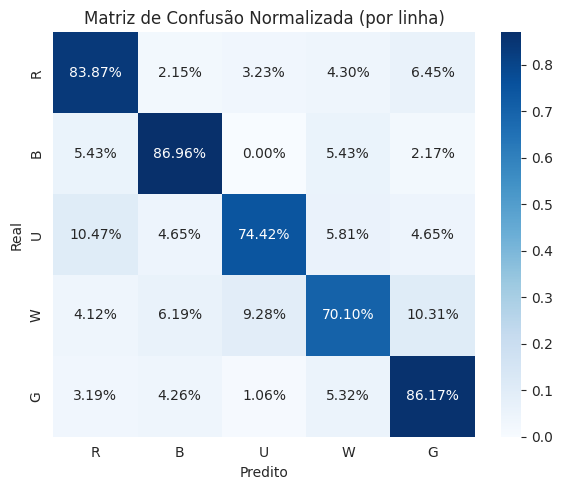

Relatório de Classificação:

              precision    recall  f1-score   support

           R      0.788     0.839     0.812        93
           B      0.833     0.870     0.851        92
           U      0.831     0.744     0.785        86
           W      0.782     0.701     0.739        97
           G      0.786     0.862     0.822        94

    accuracy                          0.803       462
   macro avg      0.804     0.803     0.802       462
weighted avg      0.803     0.803     0.802       462



In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Gera previsões no conjunto de teste
predictions = trainer_ft.predict(dataset_test_tokenized)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Tamanho do conjunto de teste
print(f"conjunto de teste: {len(true_labels)}\n")

# Matriz de confusão normalizada (porcentagens por classe real)
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

labels = list(color_to_id.keys())  # ['R', 'B', 'U', 'W', 'G']

# Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão Normalizada (por linha)")
plt.tight_layout()
plt.show()

# Relatório de classificação
report = classification_report(true_labels, pred_labels, target_names=labels, digits=3)
print("Relatório de Classificação:\n")
print(report)


In [34]:
from transformers import TextClassificationPipeline

# Cria o pipeline de inferência com o modelo treinado
pipeline = TextClassificationPipeline(
    model=model_ft,
    tokenizer=tokenizer,
    return_all_scores=False,
    device=0 if torch.cuda.is_available() else -1
)

# Número de exemplos a avaliar
n = 5  # pode alterar para outro valor

# Seleciona as primeiras n instâncias do DataFrame de teste
samples = df_test.iloc[:n]
print(color_to_id)
print(f"\nInferência sobre {n} exemplos do conjunto de teste:\n")

for i, row in samples.iterrows():
    texto = row["raw_text"]
    real = row["colors"]
    pred = pipeline(texto)[0]["label"]

    # Processa o texto para remover quebras de linha e limitar o tamanho
    texto_curto = texto[:150].replace("\n", " ")

    print(f"Exemplo {i + 1}")
    print(f"Texto       : {texto_curto}...")
    print(f"Real        : {real}")
    print(f"Predito     : {pred}")
    print("-" * 50)


Device set to use cuda:0


{'R': 0, 'B': 1, 'U': 2, 'W': 3, 'G': 4}

Inferência sobre 5 exemplos do conjunto de teste:

Exemplo 2973
Texto       : Tormod, o Profanador - Toda vez que um ou mais cards deixarem seu cemitério, crie uma ficha de criatura preta 2/2 do tipo Zumbi virada. Parceiro (Você...
Real        : B
Predito     : LABEL_1
--------------------------------------------------
Exemplo 770
Texto       : Carruagem Goblin - Ímpeto (Esta criatura pode atacar no turno em que entra em jogo sob seu controle.) A parte mais difícil de seu treinamento é aprend...
Real        : R
Predito     : LABEL_0
--------------------------------------------------
Exemplo 3981
Texto       : Abominação Nim - No final de seu turno, se Abominação Nim estiver desvirada, você perde 3 pontos de vida. É um dos mais velhos nim, embrenhado há tant...
Real        : B
Predito     : LABEL_1
--------------------------------------------------
Exemplo 1639
Texto       : Zada, Moedora de Edros - Toda vez que você conjurar uma mágica instantâ

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



In [35]:
import os
import humanize

def get_directory_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size

# Caminho da pasta de saída do projeto
output_path = "./outputs/nlp_deep_learning"

# Tamanho total em formato legível
size_bytes = get_directory_size(output_path)
print(f"Tamanho total da pasta '{output_path}': {humanize.naturalsize(size_bytes)}")


Tamanho total da pasta './outputs/nlp_deep_learning': 8.3 GB


## Usando o modelo bert para classificacao sem fine tuning



In [36]:
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification
import torch

# Nome do modelo pré-treinado em português
base_model = "neuralmind/bert-base-portuguese-cased"

# Carrega a configuração e define o número de classes
config = AutoConfig.from_pretrained(base_model)
config.num_labels = 5  # R, B, U, W, G

# Inicializa o modelo de classificação baseado no BERT em português
model_ft = BertForSequenceClassification.from_pretrained(
    base_model,
    config=config
)

# Carrega o tokenizer correspondente
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    use_fast=True
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
from transformers import Trainer, TrainingArguments

# Define the training arguments for the fine-tuned model
training_args_ft = TrainingArguments(
    output_dir=path_to_save_lm / f"{model_name}-ft_model",  # Output directory for the trained model
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=32,  # Batch size for training. May need to be lowered for free GPUs
    per_device_eval_batch_size=256,  # Batch size for evaluation. May need to be lowered for free GPUs
    num_train_epochs=5,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    # bf16=True,  # Use bf16 precision. May need to be changed to fp16 for free GPUs
    eval_strategy="epoch",  # Evaluate the model after each epoch
    logging_strategy="steps",  # Log the training progress after each step
    save_strategy="epoch",  # Save the model after each epoch
    eval_steps=1,  # Evaluate the model after every 1 epoch
    save_steps=1,  # Save the model after every 1 epoch
    logging_steps=10,  # Log the training progress after every 1 step
    load_best_model_at_end=True,  # Load the best model at the end of training
    seed=271828,  # Random seed for reproducibility
    report_to="none"
)

# Initialize the Trainer for the fine-tuned model
trainer_ft = Trainer(
    model=model_ft,  # The fine-tuned model to train
    args=training_args_ft,  # The training arguments defined above
    train_dataset=dataset_train_tokenized_classification,  # The tokenized training dataset
    eval_dataset=dataset_valid_tokenized_classification,  # The tokenized evaluation dataset
    processing_class=tokenizer,  # The tokenizer used to preprocess the input text
    data_collator=data_collator,  # The data collator for dynamic padding and batching
    compute_metrics=compute_metrics,  # The function to compute the evaluation metrics
)

# Train the fine-tuned model
trainer_ft.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.132500,1.109743,0.604091,0.604653,0.604091,0.601434
2,0.780900,0.843108,0.705174,0.707863,0.705174,0.703490
3,0.530200,0.759807,0.742479,0.744632,0.742479,0.742300
4,0.374800,0.749077,0.749699,0.752170,0.749699,0.749483
5,0.311500,0.745639,0.744886,0.746834,0.744886,0.744724


TrainOutput(global_step=520, training_loss=0.710811814895043, metrics={'train_runtime': 579.7827, 'train_samples_per_second': 28.64, 'train_steps_per_second': 0.897, 'total_flos': 4369076755614720.0, 'train_loss': 0.710811814895043, 'epoch': 5.0})

In [38]:
# Evaluate the fine-tuned model on the evaluation dataset
# This will return a dictionary containing the evaluation metrics
results_ft = trainer_ft.evaluate()

# Display the evaluation results
# The results will include metrics such as loss, accuracy, etc.
results_ft

{'eval_loss': 0.7456390857696533,
 'eval_accuracy': 0.7448856799037304,
 'eval_precision': 0.7468335522855367,
 'eval_recall': 0.7448856799037304,
 'eval_f1': 0.7447240516562519,
 'eval_runtime': 6.6468,
 'eval_samples_per_second': 125.023,
 'eval_steps_per_second': 0.602,
 'epoch': 5.0}

In [40]:
predictions_output = trainer_ft.predict(dataset_valid_tokenized_classification)


In [47]:
import numpy as np

logits = predictions_output.predictions
predicted_classes = np.argmax(logits, axis=1)
true_labels = predictions_output.label_ids


In [57]:
from sklearn.metrics import classification_report

# Define o mapeamento inverso, se necessário
id_to_color = {0: "R", 1: "B", 2: "U", 3: "W", 4: "G"}

# Substitui os índices pelos nomes das cores (opcional)
predicted_labels = [id_to_color[i] for i in predicted_classes]
true_labels_named = [id_to_color[i] for i in true_labels]

report_bert_base = classification_report(true_labels_named, predicted_labels, digits=4)
print("modelo sem fine tunning")
print(report_bert_base)
print("modelo com fine tunning")
print(report)

modelo sem fine tunning
              precision    recall  f1-score   support

           B     0.7697    0.7651    0.7674       166
           G     0.7184    0.7396    0.7289       169
           R     0.7090    0.8024    0.7528       167
           U     0.7770    0.7013    0.7372       154
           W     0.7622    0.7143    0.7375       175

    accuracy                         0.7449       831
   macro avg     0.7473    0.7445    0.7447       831
weighted avg     0.7468    0.7449    0.7447       831

modelo com fine tunning
              precision    recall  f1-score   support

           R      0.752     0.849     0.798        93
           B      0.843     0.815     0.829        92
           U      0.822     0.698     0.755        86
           W      0.737     0.722     0.729        97
           G      0.780     0.830     0.804        94

    accuracy                          0.784       462
   macro avg      0.787     0.783     0.783       462
weighted avg      0.786     0

In [62]:
# prompt: zip and download bert-base-mtg-color-classifier folder and the bert-base-finetuned-mlm folder

from google.colab import files

# Zip the two folders
!zip -r bert-base-mtg-color-classifier.zip /content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier
!zip -r bert-base-finetuned-mlm.zip /content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm




  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/ (stored 0%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/special_tokens_map.json (deflated 42%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/tokenizer_config.json (deflated 74%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/vocab.txt (deflated 52%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/config.json (deflated 57%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/tokenizer.json (deflated 72%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/model.safetensors (deflated 7%)
  adding: content/outputs/nlp_deep_learning/bert_masked_lm/bert-base-mtg-color-classifier/training_args.bin (deflated 52%)
  adding: content/outputs/nlp_deep_learning/

In [63]:
# Download the zipped files
files.download('bert-base-mtg-color-classifier.zip')
files.download('bert-base-finetuned-mlm.zip')
files.download('dataset.csv')
files.download('mtg_cards_ptbr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>